In [37]:
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
Bernoulli = tf.contrib.distributions.Bernoulli

data = input_data.read_data_sets("MNIST_data/", one_hot=True).test
data.images[data.images>0.5] = 1.0
data.images[data.images<=0.5] = 0.0

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Utilitiy functions

In [86]:
def plot_banded_error(errs, label, ax=None):
    ax = ax or plt
    m = np.mean(errs, axis=0)
    s = np.std(errs, axis=0)
    line, = ax.plot(np.arange(1, len(m)+1), m, '.-', label=label)

def fatlegend(ax, *a, **kw):
    leg = ax.legend(*a, **kw)
    for l in leg.legendHandles:
        l.set_linewidth(l.get_linewidth()*2.0)
    return leg

def add_layer(inputs, wn, bn, in_dim, out_dim, af=None):
    try:
        w = tf.get_variable(wn, [in_dim, out_dim], initializer=tf.truncated_normal_initializer)
        b = tf.get_variable(bn, [1, out_dim], initializer=tf.truncated_normal_initializer)
    except:
        with tf.variable_scope(tf.get_variable_scope(), reuse=True):
            w = tf.get_variable(wn)
            b = tf.get_variable(bn)
    if af is None:
        return tf.matmul(inputs, w) + b
    return af(tf.matmul(inputs, w) + b)

def get_weights(wn, bn):
    with tf.variable_scope(tf.get_variable_scope(), reuse=True):
        w = tf.get_variable(wn)
        b = tf.get_variable(bn)
    return [w,b]

def prob(p, s):
    return s*p+(1.0-s)*(1.0-p)

def log_prob(p, s):
    return tf.log(tf.clip_by_value(s*p+(1.0-s)*(1.0-p), eps, 1.0-eps))

def det_pass(inputs, layer, n=1):
    if layer==1:
        z = add_layer(inputs, "whh", "bhh", nh, nh, tf.nn.sigmoid)
        inputs = z
    z = prob(add_layer(inputs, "why", "bhy", nh, 392, tf.nn.sigmoid), tf.tile(y_,[n,1]))
    return tf.reduce_sum(z/tf.stop_gradient(tf.tile(-prob(y_expect, y_)-eps,[n,1])), 1, keep_dims=True)

def fg_cov(f, g, w, n):
    mf, mg = [tf.concat(tf.gradients(tf.reduce_mean(z, 0), w),0) for z in [f,g]]
    f, g = [tf.reshape(z, [n,batch_size,nh]) for z in [f,g]]
    for i in range(n):
        df, dg = [tf.concat(tf.gradients(tf.reduce_mean(z[i], 0), w), 0) for z in [f, g]]
        vg = tf.square(dg-mg) if i==0 else vg+tf.square(dg-mg)
        cov = (df-mf)*(dg-mg) if i==0 else cov+(df-mf)*(dg-mg)
    return mf, mg, cov, vg


def gd_stats(p, s, f, g, mg, dh, w):
    mdf, mdg = [tf.concat(tf.gradients(tf.reduce_mean(z,0), w), 0) for z in [f, g]]
    mgd = tf.concat([dh[0][0], dh[1][0]], 0)
    
    f, g, s = [tf.reshape(z, [ns, batch_size, nh]) for z in [f, g, s]]
    for i in range(ns):
        df, dg = [tf.concat(tf.gradients(tf.reduce_mean(z, 0), w), 0) for z in [f[i], g[i]]]
        vf = tf.square(df-mdf) if i==0 else vf+tf.square(df-mdf)
        vg = tf.square(dg-mdg) if i==0 else vg+tf.square(dg-mdg)        
        cov = (df-mdf)*(dg-mdg) if i==0 else cov+(df-mdf)*(dg-mdg)
        gd = tf.concat(tf.gradients(tf.reduce_mean(f[i]-g[i]+mg, 0), w), 0)
        vgd = tf.square(gd-mgd) if i==0 else vgd+tf.square(gd-mgd)    
    vf, vg, cov, vgd = [tf.reduce_sum(z)/(ns-1) for z in [vf, vg, cov, vgd]]
    return vf+vg-2*cov, vgd

### Parameters

In [39]:
batch_size = 4
ns = 2
lr = 1e-3
eps = 1e-7
alpha = 0.9
steps = 50000
nh = 100

### Sigmoid belief networks

In [40]:
x = tf.placeholder(tf.float32, [None, 392])
h = add_layer(x, "wxh", "bxh", 392, nh, tf.nn.sigmoid)
sh = tf.stop_gradient(tf.reshape(Bernoulli(probs=h, dtype=tf.float32).sample(ns), 
                                 [ns*batch_size, nh]))
h2 = add_layer(sh, "whh", "bhh", nh, nh, tf.nn.sigmoid)
sh2 = tf.stop_gradient(tf.reshape(Bernoulli(probs=h2, dtype=tf.float32).sample(ns),
                                  [ns*ns*batch_size, nh]))
y = add_layer(sh2, "why", "bhy", nh, 392, tf.nn.sigmoid)
y_expect = tf.reduce_mean(tf.reshape(y, [ns**2, batch_size, 392]), 0)
y_ = tf.placeholder(tf.float32, [None, 392])

nll = tf.reduce_mean(tf.reduce_sum(-log_prob(y_expect, y_), 1))
ls2 = tf.reduce_sum(prob(y, tf.tile(y_,[ns**2,1]))/
                    tf.stop_gradient(tf.tile(-prob(y_expect, y_)-eps, [ns**2,1])), 1, keep_dims=True)
ls = tf.reduce_mean(tf.reshape(ls2, [ns,ns*batch_size,1]), 0)
_h, _h2 = [tf.tile(z, [ns, 1]) for z in [h, h2]]
#saver = tf.train.Saver()

### Gradient estimators

In [81]:
bsln = tf.placeholder(tf.float32)
bslnv = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(lr)

def gd_est(md, linear, cf, sta, nn):
    func = {
        0: lambda p, s, layer, w, cf, nn: [tf.zeros([ns**layer*batch_size,1]), tf.zeros([1])],
        1: muProp,
        2: DARN,
        3: baseline,
        4: NVIL
    }
    g2, mg2 = func.get(md)(h2, sh2, 2, get_weights("whh", "bhh"), cf, nn)    
    g, mg = func.get(md)(h, sh, 1, get_weights("wxh", "bxh"), cf, nn)

    f, f2 = ls, ls2
    m = v = tf.constant(0.)
    tr = None
    
    dy = opt.compute_gradients(nll, get_weights("why", "bhy"))    
    if linear:        
        dh2 = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(f2-g2)*log_prob(_h2, sh2), 0)+
                                    tf.reduce_mean(mg2, 0), get_weights("whh", "bhh"))        
        dh  = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(f-g)*log_prob(_h, sh), 0)+
                                    tf.reduce_mean(mg, 0), get_weights("wxh", "bxh"))
    else:
        dh2 = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(f2/g2)*tf.tile(mg2,[ns,1]), 0), 
                                    get_weights("whh", "bhh"))        
        dh  = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(f/g)*tf.tile(mg,[ns,1]), 0), 
                                    get_weights("wxh", "bxh"))
    train_step = opt.apply_gradients(dy+dh2+dh if tr is None else dy+dh2+dh+tr)

    if sta:
        fp2, gp2 = [tf.stop_gradient(z)*log_prob(tf.tile(h2, [ns,1]), sh2) for z in [f2, g2]]
        fp, gp = [tf.stop_gradient(z)*log_prob(tf.tile(h, [ns,1]), sh) for z in [f, g]]
        stats1 = gd_stats(h2, sh2, fp2, gp2, mg2, dh2, get_weights("whh", "bhh"))
        stats2 = gd_stats(h, sh, fp, gp, mg, dh, get_weights("wxh", "bxh"))
        return (stats1,stats2), train_step, y_expect, nll, m, v

    return train_step, y_expect, nll, m, v

def muProp(p, s, layer, w, cf, nn):
    fh = det_pass(p, layer, ns**(layer-1))
    dfh = tf.gradients(fh, p)[0]
    coef = cv_coef(fh, dfh, p, nn, layer, w) if cf else 1.
    mg = coef*tf.stop_gradient(dfh)*p        
    fh, dfh, p, coef = [tf.tile(z, [ns,1]) for z in [fh, dfh, p, coef]]
    g = coef*(fh+tf.reduce_sum(dfh*(s-p), 1, keep_dims=True))
    return g, mg

def cv_coef(fh, dfh, p, nn, layer, w):
    p, dfh = [tf.reshape(z, [ns**(layer-1), batch_size, nh]) for z in [p, dfh]]
    fh = tf.reshape(fh, [ns**(layer-1), batch_size, 1])
    for j in range(ns**(layer-1)):
        ss = tf.stop_gradient(tf.reshape(Bernoulli(probs=p[j], dtype=tf.float32).sample(nn), 
                                         [nn*batch_size, nh]))
        sfh = det_pass(ss, layer, nn)
        _fh, _dfh, _p = [tf.tile(z, [nn,1]) for z in [fh[j], dfh[j], p[j]]]
        f = tf.stop_gradient(sfh)*log_prob(_p, ss)
        g = tf.stop_gradient(_fh+tf.reduce_sum(_dfh*(ss-_p), 1, keep_dims=True))*log_prob(_p, ss)
        _, _, cov, vg = fg_cov(f, g, w, nn)
        t = tf.tile([[tf.reduce_sum(cov)/tf.reduce_sum(vg)]],[batch_size,1])
        coef = t if j==0 else tf.concat([coef, t], 0)
    return coef

def DARN(p, s, layer, w, cf, nn):
    # only work for one layer
    if layer==1:
        return muProp(p, s, layer, w, cf, nn)
    dh = tf.gradients(ls2, s)[0] 
    g = ls2 + dh*(.5-s)
    return g, tf.zeros([1])

def baseline(p, s, layer, w, cf, nn):
    b = alpha*bsln + (1.0-alpha)*tf.reduce_mean(ls)
    g = tf.stop_gradient(b)
    return g, tf.zeros([1])

def NVIL():
    ch = add_layer(x, "wh", "bh", 392, 100, tf.tanh)
    cy = add_layer(ch, "wy", "by", 100, 1)
    b = alpha*bsln + tf.reduce_mean((1.0-alpha)*(loss-cy))
    vv = tf.reduce_mean(tf.square(loss-cy-tf.reduce_mean(loss-cy)))/tf.maximum(1.0, (ns-1))
    v = alpha*bslnv + (1.0-alpha)*vv
    g = tf.stop_gradient((cy+b)/tf.maximum(1.0,tf.sqrt(v))) * p
    f = tf.stop_gradient(loss/tf.maximum(1.0,tf.sqrt(v))) * p
    tr = opt.compute_gradients(tf.reduce_mean(tf.square(tf.stop_gradient(loss-b)-cy)), 
                               [get_weights("wh", "bh", 392, 100), get_weights("wy", "by", 100, 1)])
    return f, g, None, tr, b, v

def ST_():
    train_step = tf.train.AdamOptimizer(lr).minimize(nll)
    return train_step, nll, tf.constant(0.), tf.constant(0.)

In [82]:
def train(train_op):
    with tf.Session() as sess:
        bl = 0.
        vr = 0.
        loss_rec = np.empty((1000, steps/1000))
        time_rec = np.empty((1000, steps/1000))        
        sess.run(tf.global_variables_initializer())

        for i in range(steps):
            batch_ = data.next_batch(batch_size, shuffle=True)[0]
            batch_xs = batch_[:,0:392]
            batch_ys = batch_[:,392:784]
            
            tstart = time.clock()
            res = sess.run(train_op, {x: batch_xs, y_: batch_ys, bsln: bl, bslnv: vr})
            bl = res[-2]
            vr = res[-1]
            time_rec[i%1000, i/1000] = time.clock()-tstart            
            loss_rec[i%1000, i/1000] = res[-3]
            if (i+1)%1000==0:
                print (i+1)/1000, np.mean(loss_rec[:, i/1000], 0),
                
    return loss_rec, time_rec, batch_xs, batch_ys, res[1]

In [83]:
train_op = gd_est(1, linear=True, cf=True, sta=False, nn=4)
result = train(train_op)
mpl_b = result[0]

1 221.835360901 2 146.678272469 3 137.869337318 4 131.132374718 5 126.103154396 6 122.39928788 7 117.880501671 8 114.573528198 9 112.058827091 10 110.064388874 11 107.944834991 12 105.888080418 13 103.828455727 14 103.295986115 15 100.24470195 16 99.3542906914 17 99.4144539528 18 96.7850777435 19 95.863805687 20 94.9591738281 21 93.6508899574 22 92.5916465225 23 91.8615101242 24 91.1563857613 25 91.1256272507 26 89.9147616272 27 89.1595266914 28 88.831008522 29 88.7816200867 30 87.1264660912 31 86.9737467041 32 86.7643978462 33 85.6089409828 34 85.5332872887 35 85.6034885788 36 85.4397590485 37 84.4791912308 38 83.6560344505 39 84.0100766945 40 83.9080686493 41 82.3534736862 42 83.0053449287 43 83.0108363571 44 82.3357659225 45 82.079110157 46 82.4761465607 47 80.8607389679 48 81.4641157799 49 81.4856269608 50 81.0882821846


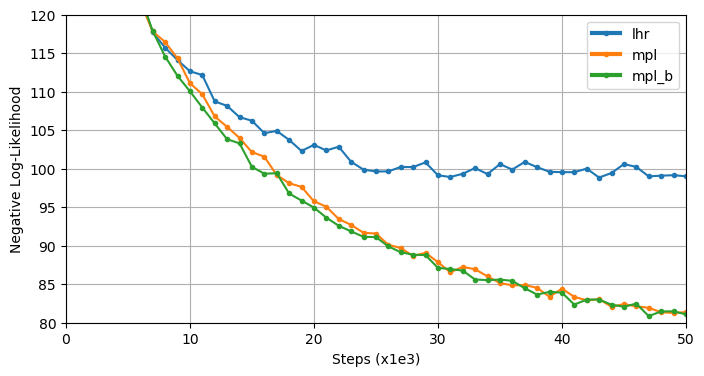

In [85]:
plt.style.use('default')
fig, ax = plt.subplots(1,1, figsize=(8,4))
plt.xlim(0, 50)
plt.ylim(80,120)

plot_banded_error(lhr, "lhr")
plot_banded_error(mpl, "mpl")
plot_banded_error(mpl_b, "mpl_b")
#plot_banded_error(dn, "dn")
#plot_banded_error(mpr, "mpr")

fatlegend(ax)
plt.ylabel("Negative Log-Likelihood")
plt.xlabel("Steps (x1e3)")
ax.grid(True)
plt.show()
#fig.savefig('foo.png')

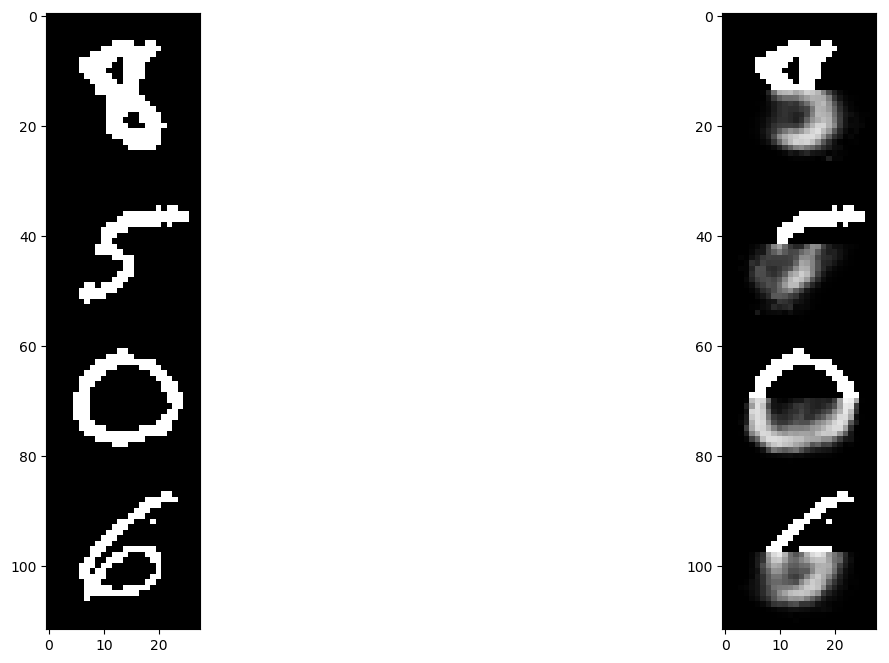

In [397]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
up = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[2]]], 1)
dw = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[3]]], 1)
p1 = np.concatenate(np.split(np.concatenate([up,dw], 0), batch_size/10, 1), 0)
dwy = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[4]]], 1)
p2 = np.concatenate(np.split(np.concatenate([up,dwy], 0), batch_size/10, 1), 0)
ax[0].imshow(p1, cmap=plt.cm.gray, interpolation='none')
ax[1].imshow(p2, cmap=plt.cm.gray, interpolation='none')
ax[0].grid(False)
ax[1].grid(False)
plt.show()